In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt

def fitness_function(genotype, benefits, volumes, max_volume):
  """
  checks if the individual is close to obtaining the optimal solution
  :param genotype: a binary genotype of an individual
  :param benefits: a given set of benefits 
  :param volumes: a given set of volumes
  :param max_volume: max allowable volume
  :return: fitness of that individual, return 0 if max_volume was exceeded
  """
  vol = 0
  ben = 0
  # iterates all nonzero elements and adds up benefits and volumes according to that
  for i in np.nonzero(genotype)[0]:  
    ben += benefits[i]
    vol += volumes[i]
  if vol > max_volume:
    return 0
  else:
    return ben

# also used this fitness fuction during coding. they both work. 
# just wanted to make sure by using the fitness function from knapsack challenge
"""
def fitness_function(genotype, benefits, volumes, max_volume):
    total_volume = 0
    fitness = 0
    # iterates through all elements but only adds benefits and volumes when genotype is 1
    for i in range(len(genotype)):
      if genotype[i] == 1:
        total_volume += volumes[i]
        if total_volume > max_volume:
          return 0
        fitness += benefits[i]
    return fitness
"""

'\ndef fitness_function(genotype, benefits, volumes, max_volume):\n    total_volume = 0\n    fitness = 0\n    # iterates through all elements but only adds benefits and volumes when genotype is 1\n    for i in range(len(genotype)):\n      if genotype[i] == 1:\n        total_volume += volumes[i]\n        if total_volume > max_volume:\n          return 0\n        fitness += benefits[i]\n    return fitness\n'

In [ ]:
class GA:
  def __init__(self, pop_size: int, generations: int, mutation_rate: float, tournament_size: int, crossover_prob: float):
    self.benefits = benefits
    self.volumes = volumes
    self.max_vol = max_volume
    self.pop_size = pop_size
    self.generations = generations
    self.num_items = len(self.benefits)
    assert len(self.benefits) == len(self.volumes), "The benefits and volumes arrays should be equal size"
    self.genotype_len = len(self.benefits)
    # initialise the population
    self.pop = self.initialise_pop()
    self.mutation_rate = mutation_rate
    self.tournament_size = tournament_size
    self.crossover_prob = crossover_prob

  def initialise_pop(self):
    """
    generates a random population
    :return: a new random population with binary genotypes
    """
    pop = np.random.choice([0, 1], (self.pop_size, self.num_items))
    return np.squeeze(pop)

  def mutate(self, individual):
    """
    mutate an individual depending on the mutation rate
    :param individual: genotype of the individual that is going to be mutated 
    :return: returns the mutated genotype of the individual
    """
    #copy.deepcopy was added to return mutated without affecting the original individual to preserve the original array
    mutated = copy.deepcopy(individual)
    for i in range(self.genotype_len):
      # np.random.random() generates random floats between 0.0 and 1.0
      if np.random.random() < self.mutation_rate:
        mutated[i] = 1 - mutated[i] # genotype bit flipping 
    return mutated

  def tournament_selection(self, fitness_values):
    """
    randomly selects tournament_size amount of individuals, compares them, and picks the fittest as a parent
    :param fitness_values: fitness values of the population in that generation
    :return: returns fittest random individual participated in the tournament
    """
    random_parent = np.random.choice(range(len(fitness_values)), self.tournament_size)
    parent_fitness = fitness_values[random_parent]
    return random_parent[np.argmax(parent_fitness)]

  def crossover(self, parent1, parent2):
    """
    select a random crossover point from the selected parents's genotypes. get the part before crossover point from 
    one parent's genotype and the part after the crossover point from the second parent to create children
    :param parent1: parent1 selected by tournament selection as the fittest among a random group of individuals.
    :param parent2: parent2 selected by tournament selection as the fittest among a random group of individuals.
    :return: returns two children called child1 and child2 that has the different part of the genes of their parrents
    """
    # this linked provided the knowledge about crossover in genetic algorithm
    # https://medium.com/@samiran.bera/crossover-operator-the-heart-of-genetic-algorithm-6c0fdcb405c0
    parent_genotype = np.random.randint(1, self.genotype_len)
    child1 = np.concatenate((parent1[parent_genotype:], parent2[:parent_genotype]))
    child2 = np.concatenate((parent2[parent_genotype:], parent1[:parent_genotype]))
    return child1, child2

  def reproduce(self, fitness_values, next_gen):
    """
    first gets the fittest individual, mutates (to avoid premature convergence) it and selects it as the first individual 
    of the next generation goes through the population uses tournament selection function to determine the parents, checks if 
    crossover needed according to crossover probaility, mutates the results and adds them to next generation
    :param fitness_values: fitness values of the population in that generation
    :param next_gen: the list that stores the individuals that are going to be passed into next generation
    :return: returns the list of individuals that are going to be passed into next generation
    """
    fittest = np.argmax(fitness_values)
    # pick the fittest of the population for the next generation (elitizm) and mutate it to avoid premature convergence
    next_gen[0] = self.mutate(self.pop[fittest])
    for i in range(1, self.pop_size):
      parent1 = self.pop[self.tournament_selection(fitness_values)]
      parent2 = self.pop[self.tournament_selection(fitness_values)]
      if np.random.random() < self.crossover_prob:
        child1, child2 = self.crossover(parent1, parent2)
      else:
        child1, child2 = parent1, parent2
      child1 = self.mutate(child1)
      child2 = self.mutate(child2)
      # can only pick one child to not to effect population size 
      # because elitizm already passes the individual with best fitness into next generation
      child1_fitness = fitness_function(child1, self.benefits, self.volumes, self.max_vol)
      child2_fitness = fitness_function(child2, self.benefits, self.volumes, self.max_vol)
      if child1_fitness > child2_fitness:
        next_gen[i] = child1
      else:
        next_gen[i] = child2
    return next_gen
  
  def evolve(self):
    """
    the main loop that generates new populations for the given number of generations and applies the functions
    that were previously written to generate new generations and finds the best genotype during the entire process
    :return: returns the best genotype found during the process
    """
    best_fitness = 0
    best_genotype = None
    # loop throug all given number of generations
    for generation in range(self.generations):
      # evaluate the fittnesses of the population and find the fittest one
      fitness_values = []
      for genotype in self.pop:
        fitness_value = fitness_function(genotype, self.benefits, self.volumes, self.max_vol)
        fitness_values.append(fitness_value)
      fitness_values = np.array(fitness_values)
      fittest = np.argmax(fitness_values)
      if fitness_values[fittest] > best_fitness:
        best_fitness = fitness_values[fittest]
        best_genotype = self.pop[fittest]
      # create a new generation
      next_gen = np.zeros((self.pop_size, self.num_items))
      next_gen = self.reproduce(fitness_values, next_gen)
      # replace the old generation with the new one.    
      self.pop = next_gen
    return best_genotype


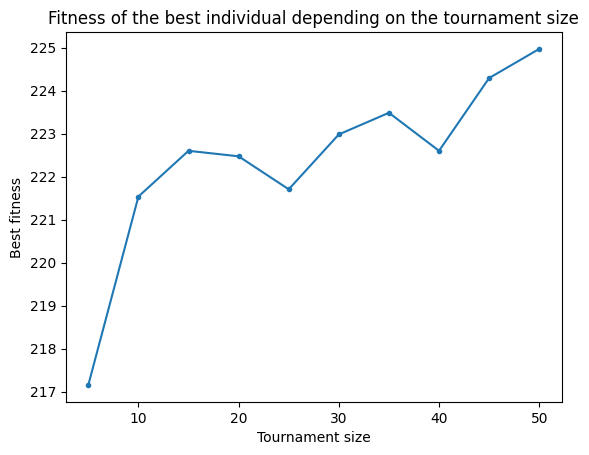

In [ ]:
#defining parameters for the GA class
pop_size = 50
generations = 5000
mutation_rate = 0.1
tournament_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
crossover_prob = 0.8

# could have randomly given values for these but found some formula in knapsack
# challange code that calculates it according to number of items
num_items = 50
volumes = np.random.randint(1, 10, num_items)
benefits = 2/3*np.sqrt(4*10**2-(volumes-2*10)**2)
max_volume = int(round(np.sum(volumes)*.45))

"""
can also use it to set random values rather than using the formula
num_items = 50
max_volume = 180
benefits = np.random.randint(1, 10, num_items)
volumes = np.random.randint(1, 10, num_items)
"""

best_fitnesses = []
for tournament_size in tournament_sizes:
  ga = GA(pop_size, generations, mutation_rate, tournament_size, crossover_prob)
  best_genotype = ga.evolve()
  best_fitness = fitness_function(best_genotype, benefits, volumes, max_volume)
  best_fitnesses.append(best_fitness)

plt.plot(tournament_sizes, best_fitnesses, marker='.')
plt.title("Fitness of the best individual depending on the tournament size")
plt.xlabel("Tournament size")
plt.ylabel("Best fitness")
plt.show()

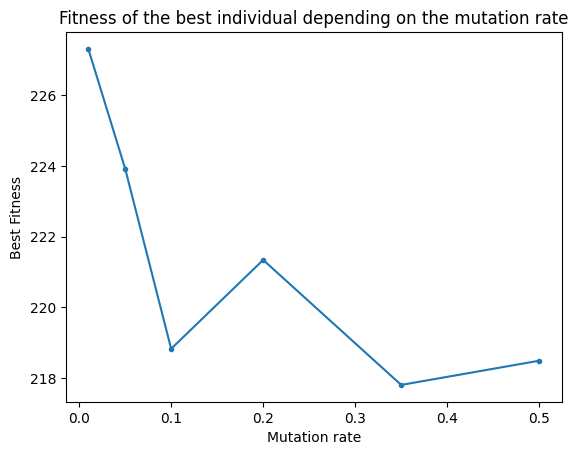

In [ ]:
pop_size = 50
generations = 5000
mutation_rates = [0.01, 0.05, 0.1, 0.2, 0.35, 0.5]
tournament_size = 5
crossover_prob = 0.8

num_items = 50
volumes = np.random.randint(1, 10, num_items)
benefits = 2/3*np.sqrt(4*10**2-(volumes-2*10)**2)
max_volume = int(round(np.sum(volumes)*.45))

best_fitnesses = []
for mutation_rate in mutation_rates:
  ga = GA(pop_size, generations, mutation_rate, tournament_size, crossover_prob)
  best_genotype = ga.evolve()
  best_fitness = fitness_function(best_genotype, benefits, volumes, max_volume)
  best_fitnesses.append(best_fitness)

plt.plot(mutation_rates, best_fitnesses, marker='.')
plt.title("Fitness of the best individual depending on the mutation rate")
plt.xlabel("Mutation rate")
plt.ylabel("Best Fitness")
plt.show()

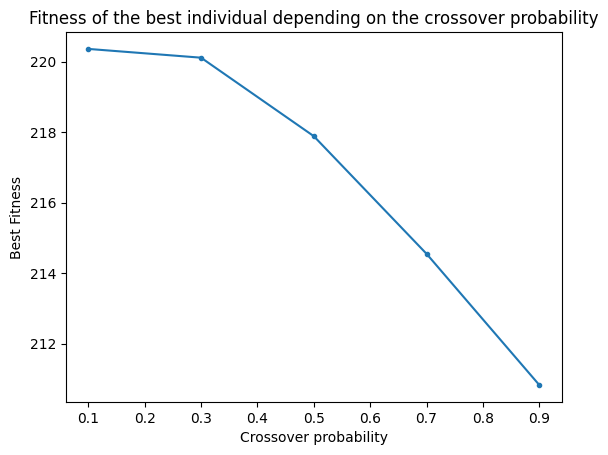

In [ ]:
pop_size = 50
generations = 5000
mutation_rate = 0.1
tournament_size = 5
crossover_probs = [0.1, 0.3, 0.5, 0.7, 0.9]

num_items = 50
volumes = np.random.randint(1, 10, num_items)
benefits = 2/3*np.sqrt(4*10**2-(volumes-2*10)**2)
max_volume = int(round(np.sum(volumes)*.45))

best_fitnesses = []
for crossover_prob in crossover_probs:
  ga = GA(pop_size, generations, mutation_rate, tournament_size, crossover_prob)
  best_genotype = ga.evolve()
  best_fitness = fitness_function(best_genotype, benefits, volumes, max_volume)
  best_fitnesses.append(best_fitness)

plt.plot(crossover_probs, best_fitnesses, marker='.')
plt.title("Fitness of the best individual depending on the crossover probability")
plt.xlabel("Crossover probability")
plt.ylabel("Best Fitness")
plt.show()